In [45]:
from datetime import datetime
import numpy as np  
import pandas as pd            
import matplotlib.pylab as plt
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

In [46]:
df = pd.read_excel('prognoz.xlsx')

In [130]:
df.head()

,Транзакционный прирост,year,month,day,weekday,isweekend,MA_7,AR_7,AR_21
0,191989,1,1,1,4,0,0,0,0
1,278538,1,1,2,5,1,0,0,0
2,429945,1,1,3,6,1,0,0,0
3,15982325,1,1,4,0,0,0,0,0
4,18725135,1,1,5,1,0,0,0,0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Дата операции           731 non-null    datetime64[ns]
 1   Приток USD              731 non-null    int64         
 2   Отток USD               731 non-null    int64         
 3   Приток KZT              731 non-null    int64         
 4   Отток KZT               731 non-null    int64         
 5   Транзакционный прирост  731 non-null    int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 34.4 KB


In [49]:
df = df.set_index('Дата операции')

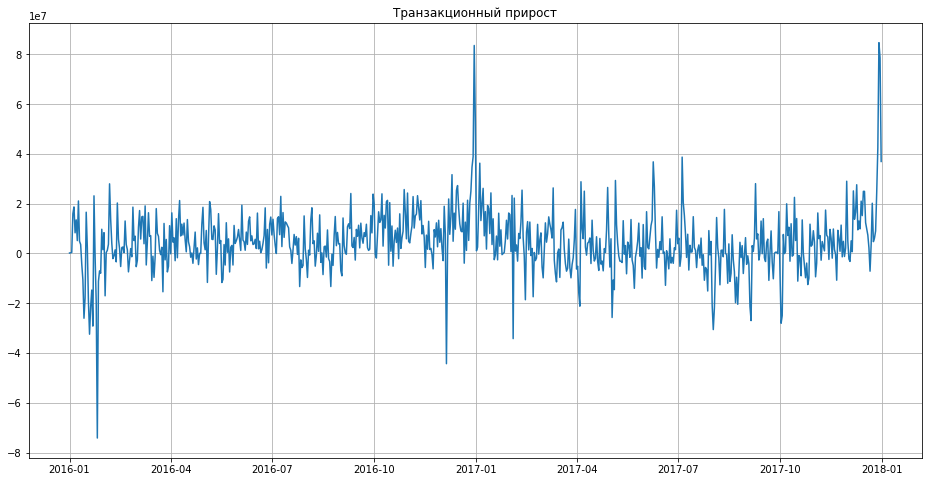

In [50]:
plt.title('Транзакционный прирост')
plt.plot(df['Транзакционный прирост'])
plt.grid(True);

По графику вроде бы можно сказать, что временной ряд стационарный с некоторыми выбросами, но это не точно. Для проверки применим наши два способо проверки стационарности.

In [51]:
rolmean = df['Транзакционный прирост'].rolling(window=30).mean()
rolstd = df['Транзакционный прирост'].rolling(window=30).std()

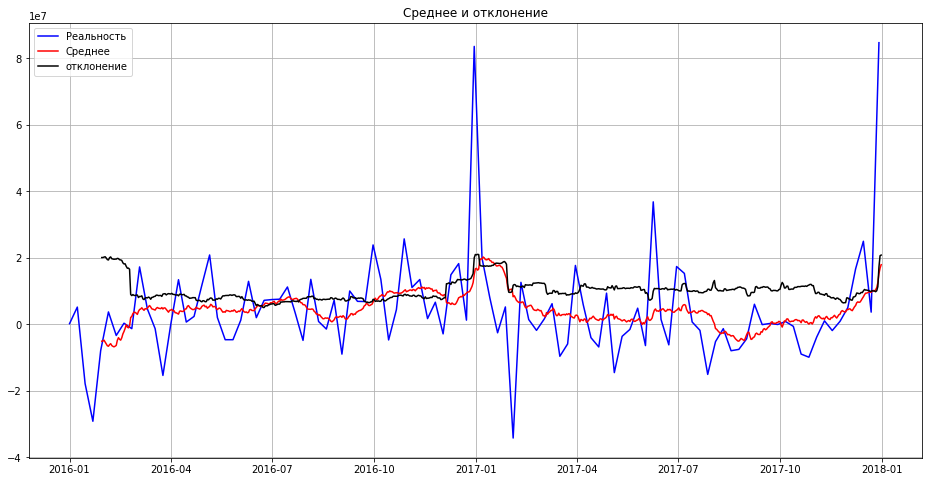

In [52]:
orig = plt.plot(df['Транзакционный прирост'][::7], color='blue', label='Реальность')
mean = plt.plot(rolmean, color='red', label='Среднее')
std = plt.plot(rolstd, color='black', label='отклонение')
plt.legend(loc='best')
plt.title('Среднее и отклонение')
plt.grid(True)

Дисперсия хоть и более менее постоянна, но среднее значение похоже имеет сезонность. Теперь проверим с помощью теста ADCF.

In [53]:
print('ADCF тест:')
dftest = adfuller(df['Транзакционный прирост'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

ADCF тест:
Test Statistic                  -2.398642
p-value                          0.142120
#Lags Used                      20.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


Тут уже очевидно, что временной ряд не стационарен, так как p-value уж имеет большое значение и также test statistic больше чем критические значения. Теперь, для того чтобы временной ряд преобразовать в стационарный вид возьмем разности рядов. Например, первые разности ряда стационарны, то он называется интегрированным рядом первого порядка.

In [54]:
df1 = df["Транзакционный прирост"].diff(periods=1).dropna()

In [55]:
rolmean = df1.rolling(window=30).mean()
rolstd = df1.rolling(window=30).std()

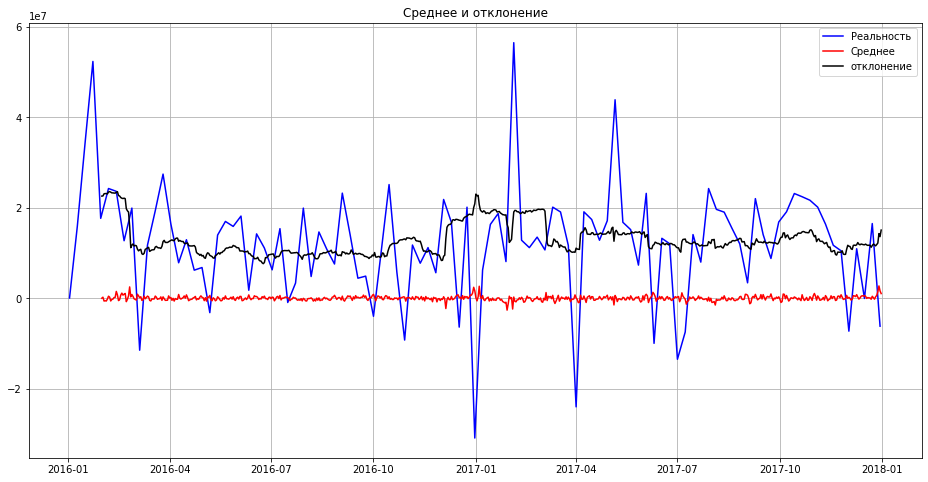

In [56]:
orig = plt.plot(df1[::7], color='blue', label='Реальность')
mean = plt.plot(rolmean, color='red', label='Среднее')
std = plt.plot(rolstd, color='black', label='отклонение')
plt.legend(loc='best')
plt.title('Среднее и отклонение')

plt.grid(True)

In [57]:
print('ADCF тест:')
dftest = adfuller(df1, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

ADCF тест:
Test Statistic                -8.451026e+00
p-value                        1.662276e-13
#Lags Used                     2.000000e+01
Number of Observations Used    7.090000e+02
Critical Value (1%)           -3.439607e+00
Critical Value (5%)           -2.865625e+00
Critical Value (10%)          -2.568945e+00
dtype: float64


Тут уже очевидно, что временной ряд стационарен. Видно по маленькому значение p-value и test-statistics намного меньше чем критические значения.

Так как мы привели временной ряд к стационарности дифференцируя один раз,можно утверждать , что нашли один из гиперпараметров модели ARIMA и это I=1.

Далее для нахождения остальных гиперпараметров P и Q, нужно построить графики ACF, PACF.

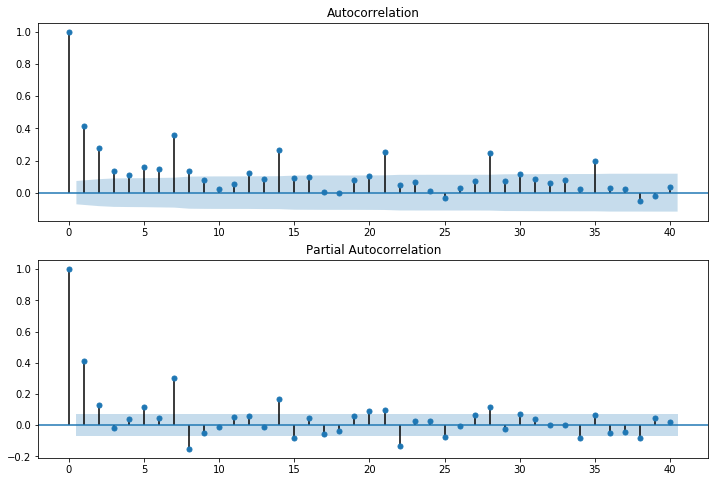

In [58]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df["Транзакционный прирост"], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df["Транзакционный прирост"], lags=40, ax=ax2)

Далее для нахождения остальных гиперпараметров P и Q, нужно построить графики ACF, PACF.

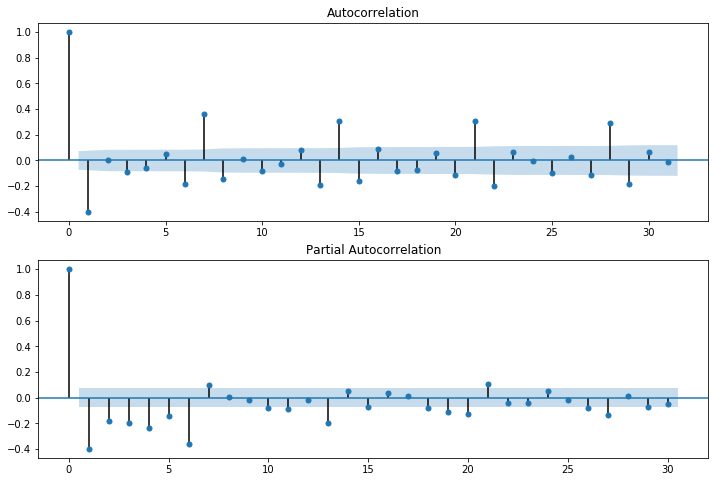

In [59]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df1, lags=31, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df1, lags=30, ax=ax2)

Здесь мы видим, что у acf и pacf есть повторяющиеся шаблоны каждые 7 периодов. Указывает на наличие недельного паттерна.
Каждый раз, когда виден обычный шаблон на одном из этих графиков, вы должны подозревать, что
Значительная сезонная вещь происходит. Тогда мы должны начать рассматривать SARIMA, чтобы взять сезонность в учет.

In [60]:
arima_mod7 = sm.tsa.ARIMA(df['Транзакционный прирост'], (6,1,1)).fit(disp=False)

/Users/akhmediyarbagdatov/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/akhmediyarbagdatov/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [136]:
# print(arima_mod7.summary())

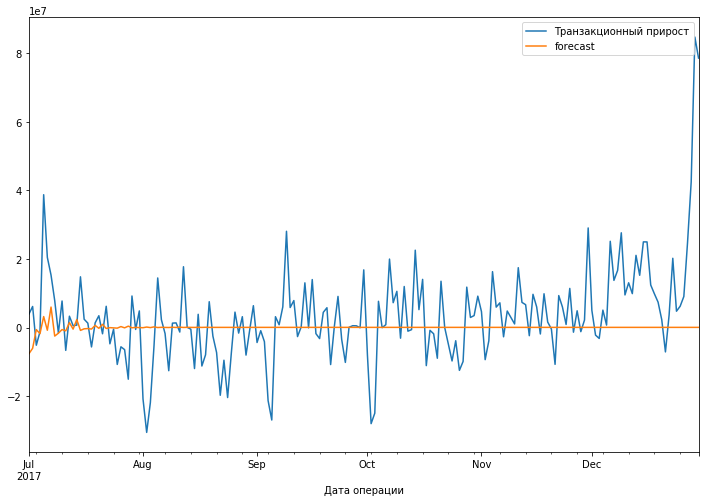

In [62]:
start_index = 547
df['forecast'] = arima_mod7.predict(start = start_index, end= 730, dynamic= True)  
df[start_index:730][['Транзакционный прирост', 'forecast']].plot(figsize=(12, 8))

NormaltestResult(statistic=114.23495772937352, pvalue=1.5638464509545303e-25)


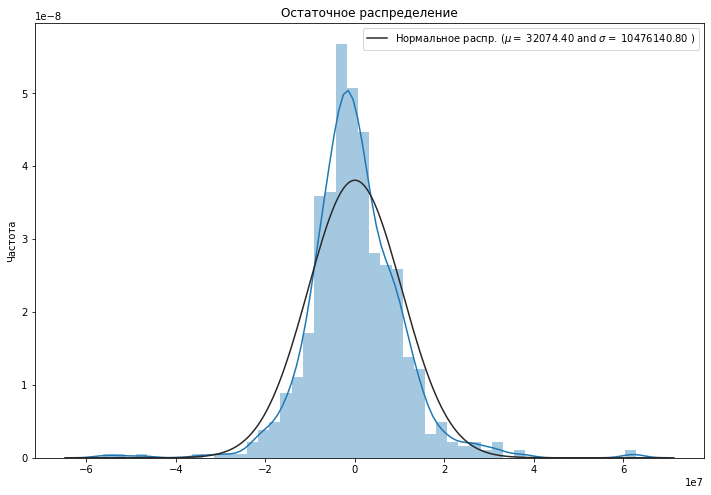

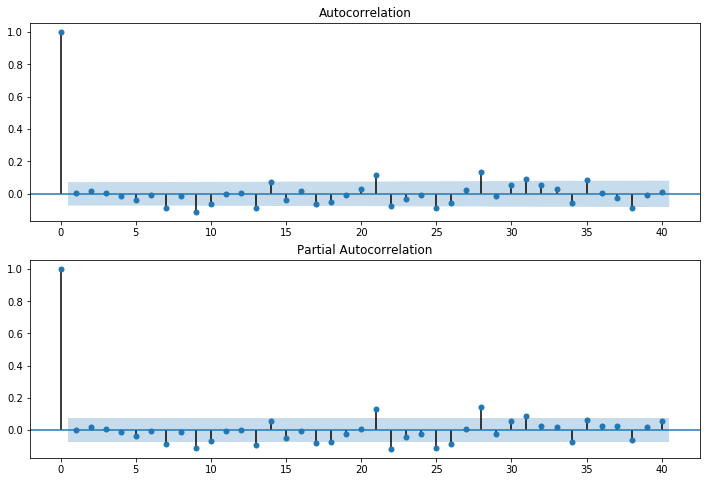

In [63]:
from scipy import stats
from scipy.stats import normaltest
import seaborn as sns

resid = arima_mod7.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0)

(mu, sigma) = stats.norm.fit(resid)

plt.legend(['Нормальное распр. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Частота')
plt.title('Остаточное распределение')

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod7.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod7.resid, lags=40, ax=ax2)

Хотя график выглядит очень похоже на нормальное распределение. Но это не прошло испытание. Также мы видим, что существует повторяющаяся корреляция как в ACF, так и в PACF. Таким образом, мы должны иметь дело с сезонностью.

In [64]:
df = df.drop(['Приток USD','Отток USD','Приток KZT','Отток KZT'],axis=1)

In [65]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [66]:
smape_kun(df[547:730]['Транзакционный прирост'],df[547:730]['forecast'])

MAPE: 102.43 % 
SMAPE: 188.57 %


In [168]:
df = pd.read_excel('prognoz.xlsx')

In [169]:
df['year'] = df['Дата операции'].dt.year - 2015
df['month'] = df['Дата операции'].dt.month
df['day'] = df['Дата операции'].dt.day
df['weekday'] = df['Дата операции'].dt.weekday
df['isweekend'] = [1 if df['weekday'][i]==5 or df['weekday'][i]==6 else 0 for i in range(len(df))]

In [170]:
df.head()

,Дата операции,Приток USD,Отток USD,Приток KZT,Отток KZT,Транзакционный прирост,year,month,day,weekday,isweekend
0,2016-01-01,10000,122953,1899647,1584705,191989,1,1,1,4,0
1,2016-01-02,2942,115059,2706416,2315761,278538,1,1,2,5,1
2,2016-01-03,263,147905,3548855,2971268,429945,1,1,3,6,1
3,2016-01-04,13533594,9363025,23528654,11716898,15982325,1,1,4,0,0
4,2016-01-05,36769881,32769452,37289979,22565273,18725135,1,1,5,1,0


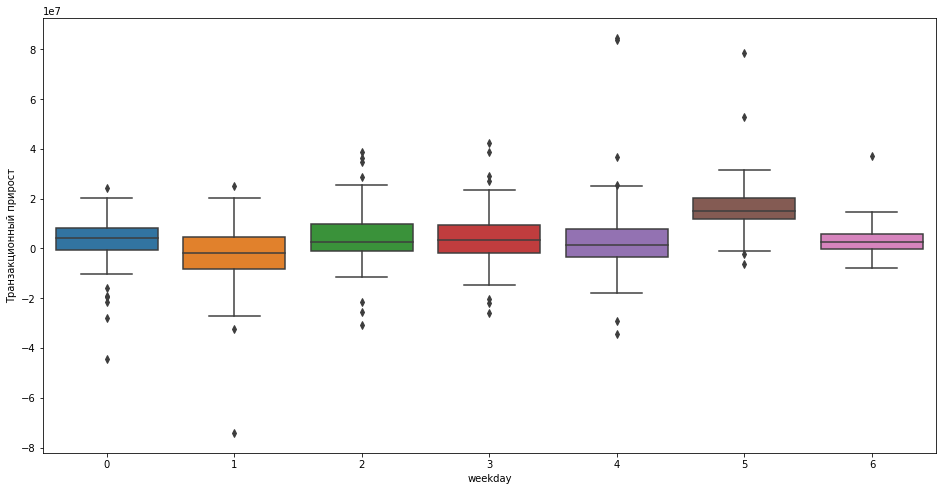

In [171]:
sns.boxplot(x="weekday", y="Транзакционный прирост", data=df)

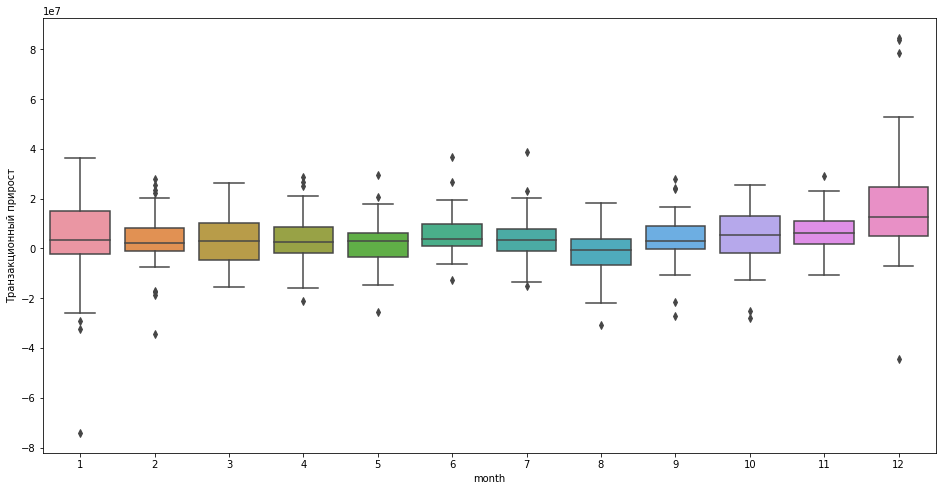

In [172]:
sns.boxplot(x="month", y="Транзакционный прирост", data=df)

In [173]:
# df = pd.get_dummies(df, columns = ['month','weekday'] , prefix = ['month','weekday'])

In [174]:
df.head()

,Дата операции,Приток USD,Отток USD,Приток KZT,Отток KZT,Транзакционный прирост,year,month,day,weekday,isweekend
0,2016-01-01,10000,122953,1899647,1584705,191989,1,1,1,4,0
1,2016-01-02,2942,115059,2706416,2315761,278538,1,1,2,5,1
2,2016-01-03,263,147905,3548855,2971268,429945,1,1,3,6,1
3,2016-01-04,13533594,9363025,23528654,11716898,15982325,1,1,4,0,0
4,2016-01-05,36769881,32769452,37289979,22565273,18725135,1,1,5,1,0


In [175]:
df = df.drop(['Дата операции'],axis=1)
df = df.drop(['Приток USD','Отток USD','Приток KZT','Отток KZT'],axis=1)

In [176]:
# %%time
# sarimax_mod6 = sm.tsa.statespace.SARIMAX(endog = df['Транзакционный прирост'][:547],
#                                         trend='n', order=(6,1,0), seasonal_order=(1,1,1,52)).fit()

In [177]:
# sarimax_mod6.forecast(steps = 184,exog = df['Транзакционный прирост'][547:730])

In [178]:
# start_index = '2017-07-01'
# end_index = '2017-12-31'

In [179]:
# df['forecast'] = sarimax_mod6.predict(start = pd.to_datetime(start_index), end= pd.to_datetime(end_index),
#                                             exog =df[start_index:end_index], 
#                                             dynamic= True)  
# df[start_index:end_index][['Транзакционный прирост', 'forecast']].plot(figsize=(12, 8))

In [180]:
# smape_kun(df[start_index:end_index]['Транзакционный прирост'],df[start_index:end_index]['forecast'])

In [181]:
# from scipy import stats
# from scipy.stats import normaltest
# import seaborn as sns

# resid = sarimax_mod6.resid
# print(normaltest(resid))

# fig = plt.figure(figsize=(12,8))
# ax0 = fig.add_subplot(111)

# sns.distplot(resid ,fit = stats.norm, ax = ax0)

# (mu, sigma) = stats.norm.fit(resid)

# plt.legend(['Нормальное распр. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
# plt.ylabel('Частота')
# plt.title('Остаточное распределение')

# fig = plt.figure(figsize=(12,8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(sarima_mod6.resid, lags=40, ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(sarima_mod6.resid, lags=40, ax=ax2)

In [182]:
dft = df[:547]

In [183]:
dft['MA_7'] = 0
dft['AR_7'] = 0
dft['AR_21'] = 0

/Users/akhmediyarbagdatov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/akhmediyarbagdatov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/akhmediyarbagdatov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [184]:
# dft = dft.drop(['AR_14'],axis=1)

In [185]:
dft.head()

,Транзакционный прирост,year,month,day,weekday,isweekend,MA_7,AR_7,AR_21
0,191989,1,1,1,4,0,0,0,0
1,278538,1,1,2,5,1,0,0,0
2,429945,1,1,3,6,1,0,0,0
3,15982325,1,1,4,0,0,0,0,0
4,18725135,1,1,5,1,0,0,0,0


In [186]:
for i in range(7,547):
    s = 0
    for j in range(i-7,i):
        s += dft['Транзакционный прирост'][j]
    dft['MA_7'][i] = s/7

/Users/akhmediyarbagdatov/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [187]:
dft['AR_7'] = [df['Транзакционный прирост'][i-7] if i>6 else 0 for i in range(0,547)]
dft['AR_21'] = [df['Транзакционный прирост'][i-21] if i>20 else 0 for i in range(0,547)]

/Users/akhmediyarbagdatov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/akhmediyarbagdatov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [188]:
test_index = len(dft)-181
X_train = dft[:366].drop(["Транзакционный прирост"], axis=1)
y_train = dft[:366]["Транзакционный прирост"]
X_test = dft[366:].drop(["Транзакционный прирост"], axis=1)
y_test = dft[366:]["Транзакционный прирост"]

In [189]:
X_test

,year,month,day,weekday,isweekend,MA_7,AR_7,AR_21
366,2,1,1,6,1,37225977,5272527,4921294
367,2,1,2,0,0,36628765,20269475,16233820
368,2,1,3,1,0,34095269,25025189,9761170
369,2,1,4,2,0,33097177,34706324,25374992
370,2,1,5,3,0,33325848,38925321,27304160
...,...,...,...,...,...,...,...,...
542,2,6,26,0,0,-2402907,566472,1860183
543,2,6,27,1,0,-2706811,-12798767,6385570
544,2,6,28,2,0,-1441737,1104596,11234399
545,2,6,29,3,0,-1270951,-1552073,13427455


[13:35:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


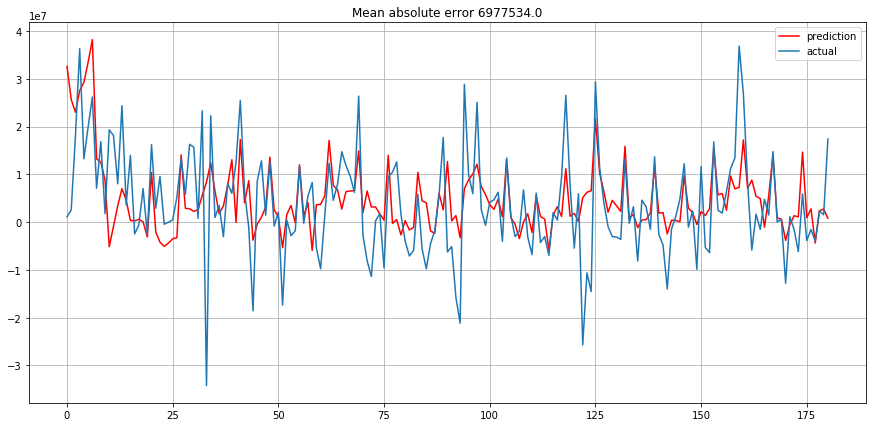

In [190]:
import xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
model = xgboost.XGBRegressor()
from sklearn.ensemble import RandomForestRegressor
model.fit(X_train, y_train)
prediction = model.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction,'r', label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Mean absolute error {}".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [191]:
dftest = df[547:]

In [192]:
dftest['Транзакционный прирост'] = 0

/Users/akhmediyarbagdatov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [193]:
df_new = pd.concat([dft, dftest])

In [194]:
df_new

,Транзакционный прирост,year,month,day,weekday,isweekend,MA_7,AR_7,AR_21
0,191989,1,1,1,4,0,0.0,0.0,0.0
1,278538,1,1,2,5,1,0.0,0.0,0.0
2,429945,1,1,3,6,1,0.0,0.0,0.0
3,15982325,1,1,4,0,0,0.0,0.0,0.0
4,18725135,1,1,5,1,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
726,0,2,12,27,2,0,NaN,NaN,NaN
727,0,2,12,28,3,0,NaN,NaN,NaN
728,0,2,12,29,4,0,NaN,NaN,NaN
729,0,2,12,30,5,1,NaN,NaN,NaN


In [195]:
pp1 = []
for i in range(547,731):
    s = 0
    for j in range(i-7,i):
        s += df_new['Транзакционный прирост'][j]
    df_new['MA_7'][i] = s/7
    s = 0
    df_new['AR_7'][i] = df_new['Транзакционный прирост'][i-7]
    df_new['AR_21'][i] = df_new['Транзакционный прирост'][i-21]
    df_new1 = df_new.drop(['Транзакционный прирост'],axis=1)
    df_new['Транзакционный прирост'][i] = int(model.predict(df_new1[i:i+1]))
    pp1.append(int(model.predict(df_new1[i:i+1])))

/Users/akhmediyarbagdatov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/akhmediyarbagdatov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/akhmediyarbagdatov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__ma

In [196]:
("Mean absolute error {}".format(round(mean_absolute_error(df['Транзакционный прирост'][547:], pp1))))

'Mean absolute error 9385173.0'

In [98]:
df = pd.read_excel('prognoz.xlsx')

In [99]:
df['year'] = df['Дата операции'].dt.year - 2015
df['month'] = df['Дата операции'].dt.month
df['day'] = df['Дата операции'].dt.day
df['weekday'] = df['Дата операции'].dt.weekday
df['isweekend'] = [1 if df['weekday'][i]==5 or df['weekday'][i]==6 else 0 for i in range(len(df))]

In [100]:
df = df.drop(['Дата операции'], axis=1)
df = df.drop(['Приток USD','Отток USD','Приток KZT','Отток KZT'],axis=1)

In [101]:
df['MA_7'] = 0
df['AR_7'] = 0
df['AR_21'] = 0

In [102]:
for i in range(7,547):
    s = 0
    for j in range(i-7,i):
        s += df['Транзакционный прирост'][j]
    df['MA_7'][i] = s/7

In [103]:
df['AR_7'] = [df['Транзакционный прирост'][i-7] if i>6 else 0 for i in range(0,731)]
df['AR_21'] = [df['Транзакционный прирост'][i-21] if i>20 else 0 for i in range(0,731)]

In [104]:
test_index = len(df)-184
X_train = df.loc[:547].drop(["Транзакционный прирост"], axis=1)
y_train = df.loc[:547]["Транзакционный прирост"]
X_test = df.loc[547:].drop(["Транзакционный прирост"], axis=1)
y_test = df.loc[547:]["Транзакционный прирост"]

[13:03:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


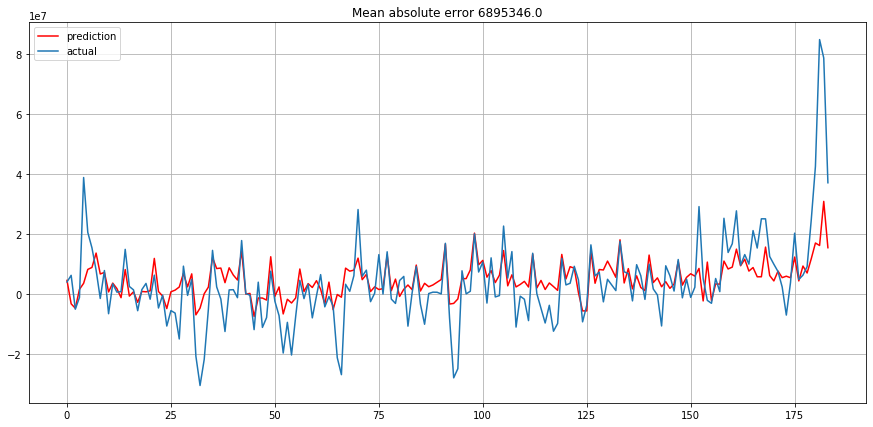

In [105]:
import xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
model = xgboost.XGBRegressor()
from sklearn.ensemble import RandomForestRegressor
model.fit(X_train, y_train)
prediction = model.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction,'r', label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Mean absolute error {}".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [106]:
df = pd.read_excel('prognoz.xlsx')

In [107]:
df['year'] = df['Дата операции'].dt.year - 2015
df['month'] = df['Дата операции'].dt.month
df['day'] = df['Дата операции'].dt.day
df['weekday'] = df['Дата операции'].dt.weekday
df['isweekend'] = [1 if df['weekday'][i]==5 or df['weekday'][i]==6 else 0 for i in range(len(df))]
df = df.drop(['Дата операции'], axis=1)
df = df.drop(['Приток USD','Отток USD','Приток KZT','Отток KZT'],axis=1)

In [108]:
df['MA_7'] = 0
df['AR_7'] = 0
df['AR_21'] = 0
for i in range(7,547):
    s = 0
    for j in range(i-7,i):
        s += df['Транзакционный прирост'][j]
    df['MA_7'][i] = s/7
df['AR_7'] = [df['Транзакционный прирост'][i-7] if i>6 else 0 for i in range(0,731)]
df['AR_21'] = [df['Транзакционный прирост'][i-21] if i>20 else 0 for i in range(0,731)]

In [109]:
import datetime

from datetime import date, timedelta

sdate = date(2018, 1, 1)   # start date
edate = date(2018, 6, 30)   # end date

delta = edate - sdate       # as timedelta
s = []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    s.append(day)

In [110]:
df_test = pd.Series(s,name='Дата операции')
df_test = df_test.to_frame()
df_test['Дата операции'] = pd.to_datetime(df_test['Дата операции'])

In [111]:
ll = pd.Series([i for i in range(731,912)])
df_test = df_test.set_index(ll)

In [112]:
df_test

,Дата операции
731,2018-01-01
732,2018-01-02
733,2018-01-03
734,2018-01-04
735,2018-01-05
...,...
907,2018-06-26
908,2018-06-27
909,2018-06-28
910,2018-06-29


In [113]:
df_test['year'] = df_test['Дата операции'].dt.year - 2015
df_test['month'] = df_test['Дата операции'].dt.month
df_test['day'] = df_test['Дата операции'].dt.day
df_test['weekday'] = df_test['Дата операции'].dt.weekday
df_test['isweekend'] = [1 if df_test['weekday'][i]==5 or df_test['weekday'][i]==6 else 0 for i in range(731,912)]

In [114]:
df_ans = pd.Series(s,name='Дата операции')
df_ans = df_ans.to_frame()
df_ans['Дата операции'] = pd.to_datetime(df_ans['Дата операции'])

In [115]:
df_ans

,Дата операции
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05
...,...
176,2018-06-26
177,2018-06-27
178,2018-06-28
179,2018-06-29


In [116]:
df_test1 = df_test.drop(['Дата операции'],axis=1)

In [117]:
df_x = pd.concat([df, df_test1])

In [118]:
df_x

,Транзакционный прирост,year,month,day,weekday,isweekend,MA_7,AR_7,AR_21
0,191989.0,1,1,1,4,0,0.0,0.0,0.0
1,278538.0,1,1,2,5,1,0.0,0.0,0.0
2,429945.0,1,1,3,6,1,0.0,0.0,0.0
3,15982325.0,1,1,4,0,0,0.0,0.0,0.0
4,18725135.0,1,1,5,1,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
907,NaN,3,6,26,1,0,NaN,NaN,NaN
908,NaN,3,6,27,2,0,NaN,NaN,NaN
909,NaN,3,6,28,3,0,NaN,NaN,NaN
910,NaN,3,6,29,4,0,NaN,NaN,NaN


In [119]:
pp = []
for i in range(731,912):
    s = 0
    for j in range(i-7,i):
        s += df_x['Транзакционный прирост'][j]
    df_x['MA_7'][i] = s/7
    s = 0
    df_x['AR_7'][i] = df_x['Транзакционный прирост'][i-7]
    df_x['AR_21'][i] = df_x['Транзакционный прирост'][i-21]
    df_xx = df_x.drop(['Транзакционный прирост'],axis=1)
    df_x['Транзакционный прирост'][i] = int(model.predict(df_xx[i:i+1]))
    pp.append(int(model.predict(df_xx[i:i+1])))

/Users/akhmediyarbagdatov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/akhmediyarbagdatov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/akhmediyarbagdatov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__ma

In [120]:
pop = pd.Series(pp)
results = pd.concat([df_ans, pop],axis=1)

In [121]:
results

,Дата операции,0
0,2018-01-01,6153359
1,2018-01-02,4050831
2,2018-01-03,16684648
3,2018-01-04,16365602
4,2018-01-05,16000694
...,...,...
176,2018-06-26,-262240
177,2018-06-27,1219331
178,2018-06-28,3002580
179,2018-06-29,3573578


In [122]:
results = results.rename(columns={0: 'Транзакционный прирост'})

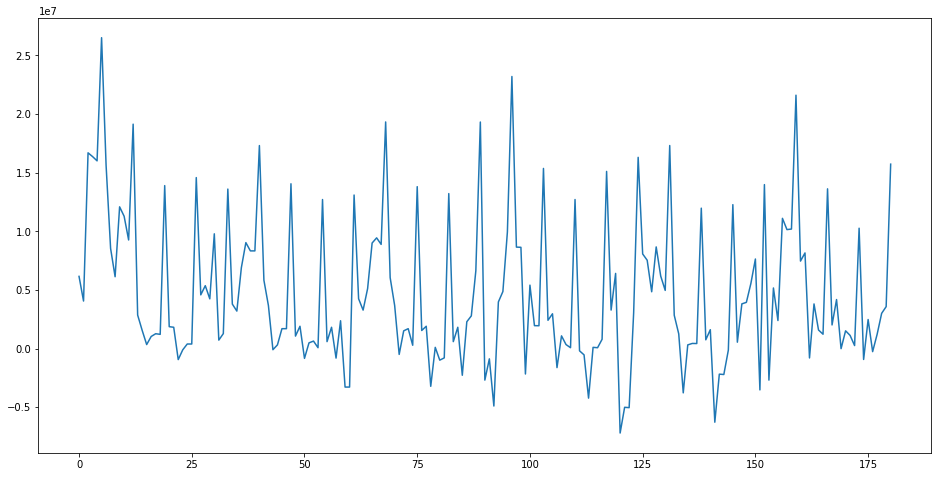

In [123]:
plt.plot(results['Транзакционный прирост'])

   Транзакционный прирост
1               231874652
2               119590510
3               135190453
4               112019832
5                98396359
6               147505477


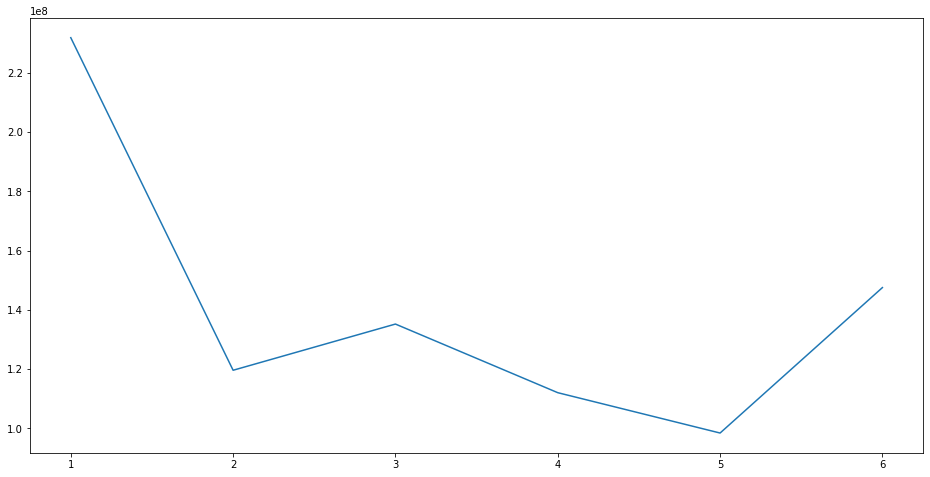

In [124]:
results['year'] = results['Дата операции'].dt.year - 2015
results['month'] = results['Дата операции'].dt.month
g = results['Транзакционный прирост'].groupby(by=[results['year'], results['month']]).sum()
g = pd.DataFrame(g)
lll = pd.Series([i for i in range(1,7)])
g = g.set_index(lll)
print(g)
plt.plot(g)

In [415]:
g.to_excel("case_1.xlsx",index=False)